## Whole Genome Sequenced Mycobacterium bovis analysis for BTBgenie.

Note: the current version of the M.bovis genome online has genes missing in the annotation. See https://www.ncbi.nlm.nih.gov/nuccore/LT708304.1?report=graph

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* [Woodchester Park eLife paper](https://elifesciences.org/articles/45833)
* http://www.htslib.org/doc/bcftools.html
* https://mtbgenomicsworkshop.readthedocs.io/
* [BCFtools cheat sheet](https://gist.github.com/elowy01/93922762e131d7abd3c7e8e166a74a0b)
* https://pypi.org/project/pyfaidx/
* https://biopython.org/wiki/Category:Cookbook
* https://pyvcf.readthedocs.io/en/v0.4.6/INTRO.html

In [1]:
import sys,os,shutil,subprocess
import random
import glob, time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
sys.path.append('pathogenie')
from pathogenie import tools, aligners, app, trees

## test set of Mbovis samples

In [2]:
import enasearch
data = enasearch.search_data(
    free_text_search=True,
    query="ERR2693227",
    result="read_run",
    display="report")

In [ ]:
enasearch.retrieve_run_report(accession="ERR2693227", fields="run_accession,instrument_platform,instrument_model,library_layout,library_strategy,center_name,study_title,read_count,fastq_ftp")

In [ ]:
enasearch.get_returnable_fields(result="read_run", verbose=False)

In [ ]:
import xml.etree.ElementTree as et 

xtree = et.parse("ena_1765_read_run.xml")

def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[1:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

df=parse_XML("ena_1765_read_run.xml", ['accession','TITLE'])
df.to_csv('ena_runs_mbovis.csv',index=False)

In [2]:
sra = pd.read_csv('sra_mbovis_runtable.csv')
#sra.geo_loc_name_country.value_counts()
sub=sra[(sra.geo_loc_name_country=='Ireland') & (sra.Host=='COW') ]
cols = ['Run','geo_loc_name_country','DATASTORE filetype','LibraryLayout','Host','ReleaseDate','Bytes']
print (sub[cols])


              Run geo_loc_name_country DATASTORE filetype LibraryLayout Host           ReleaseDate        Bytes
4405  SRR10482932              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  252763749.0
4406  SRR10482933              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  226451145.0
4407  SRR10482934              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  200402392.0
4408  SRR10482935              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  158908297.0
4409  SRR10482936              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  253008968.0
4413  SRR10482941              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  241530862.0
4415  SRR10482943              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  251394652.0
4417  SRR10482945              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  2468

In [ ]:
# fetch from SRA
def fetch_sra_reads(df):
    #download a subset of reads
    path = '/storage/btbgenie/mbovis_sra'
    for i,r in df.iterrows():        
        files = glob.glob(os.path.join(path,r.Run+'*'))        
        if len(files)==0:
            cmd = 'fastq-dump --split-3 {n} --outdir {o}'.format(n=r.Run,o=path)
            print (cmd)
            subprocess.check_output(cmd,shell=True)
        
fetch_sra_reads(sub[8:9])

## Blasting to known contaminants

* https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2684-x#Sec2

In [3]:
#get unmapped reads from a bam file

infile='mapped/3_S57_L001.bam'
cmd = 'samtools view -b -f 4 {i} > unmapped.bam'.format(i=infile)
print (cmd)
#align with bwa to known index of contaminants


samtools view -b -f 4 mapped/3_S57_L001.bam > unmapped.bam


### Examine FASTQ file quality and define trimming parameters

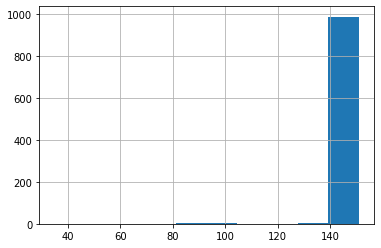

In [4]:
reload(tools)

df = tools.fastq_to_dataframe(testfile)
df.length.hist()

64.20850825309753


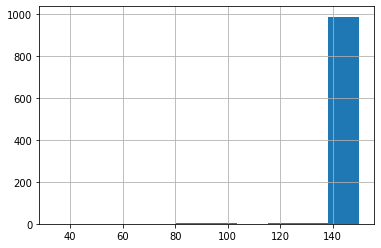

In [431]:
def trim_reads_default(filename,  outfile, right_quality=30):
    """Trim adapters"""
        
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    c=0
    out = gzopen(outfile, "wt")
    for record in fastq_parser:
        score = record.letter_annotations["phred_quality"]         
        for i in range(len(score)-1,0,-1):
            if score[i] >= right_quality:
                break
        #trimmed.append(record[:i])
        #print (record[:i])        
        #c+=1
        #if c>100:
        #    break    
        SeqIO.write(record[:i],out,'fastq')
    return

st=time.time()
trim_reads_default(testfile,'trimmed.fastq.gz')
print (time.time()-st)
df = tools.fastq_to_dataframe('trimmed.fastq.gz')
df.length.hist()

### multiprocess trimming

In [439]:
def split_fastq(filename, chunksize=100000):
    
    names=[]
    record_iter = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    for i, batch in enumerate(tools.batch_iterator(record_iter, chunksize)):
        tempfile = "group_%i.fastq" % (i + 1)
        names.append(tempfile)
        with open(tempfile, "w") as handle:
            count = SeqIO.write(batch, handle, "fastq")
        print("Wrote %i records to %s" % (count, tempfile))
    return names

split_fastq(testfile)

Wrote 465388 records to group_1.fastq


['group_1.fastq']

In [ ]:
tools.plot_fastq_qualities(testfile,limit=100000)
plt.savefig('fastq_quals.png',dpi=100)
tools.plot_fastq_gc_content(testfile, limit=50000)
plt.savefig('gc.png',dpi=100)

In [254]:
reload(tools)
tools.trim_adapters(testfile, 'trimmed.fastq.gz')

cutadapt -O 5 -q 20 albania/3_S57_L001-4_R1_001.fastq.gz -o trimmed.fastq.gz


### Get sample ids from fastq files

In [3]:
path1='albania'
files = glob.glob(os.path.join(path1,'*.fastq.gz'))
#path2='/storage/btbgenie/mbovis_sra'
path2='mbovis_sra'
files = glob.glob(os.path.join(path2,'*.fastq.gz'))

def get_files_from_paths(paths):
    """Get files in multiple paths"""
    
    files=[]
    for path in paths:
        s = glob.glob(os.path.join(path,'*.fastq.gz'))
        files.extend(s)
    return files

files = get_files_from_paths([path1,path2])
       
from collections import defaultdict

def get_sample_names(filenames, sep='-'):
    """Get sample pairs from list of fastq files."""

    res = []
    cols = ['name','sample','filename']
    for filename in filenames:
        name = os.path.basename(filename).split('.')[0]
        sample = name.split(sep)[0]
        #if we can't get sample name try another delimeter?
        if name == sample:
            sample = name.split('_')[0]
        x = [name, sample, filename]
        res.append(x)

    df = pd.DataFrame(res, columns=cols)
    df = df.sort_values(['name','sample']).reset_index(drop=True)
    df['pair'] = df.groupby('sample').cumcount()+1
    #df = df.sort_values(['name','sample','pair']).reset_index(drop=True)
    return df

df = get_sample_names(files)
df
#df.set_index(['sample','pair']).unstack()


,name,sample,filename,pair
0,3_S57_L001-4_R1_001,3_S57_L001,albania/3_S57_L001-4_R1_001.fastq.gz,1
1,3_S57_L001-4_R2_001,3_S57_L001,albania/3_S57_L001-4_R2_001.fastq.gz,2
2,6_S7_L001-4_R1_001,6_S7_L001,albania/6_S7_L001-4_R1_001.fastq.gz,1
3,6_S7_L001-4_R2_001,6_S7_L001,albania/6_S7_L001-4_R2_001.fastq.gz,2
4,7_S6_L001-4_R1_001,7_S6_L001,albania/7_S6_L001-4_R1_001.fastq.gz,1
5,7_S6_L001-4_R2_001,7_S6_L001,albania/7_S6_L001-4_R2_001.fastq.gz,2
6,SRR1791711_1,SRR1791711,mbovis_sra/SRR1791711_1.fastq.gz,1
7,SRR1791711_2,SRR1791711,mbovis_sra/SRR1791711_2.fastq.gz,2
8,SRR5486071_1,SRR5486071,mbovis_sra/SRR5486071_1.fastq.gz,1
9,SRR5486071_2,SRR5486071,mbovis_sra/SRR5486071_2.fastq.gz,2


### Align the FASTQ files against reference and create VCF files

In [ ]:
reload(aligners)
ref = app.ref_genome
samples = get_sample_names(files)

app.align_reads(samples, idx=ref, threads=10, overwrite=False)

In [16]:
def get_samples():
    import vcf
    vcf_reader = vcf.Reader(open('mapped/calls.vcf.gz', 'rb'))
    vcf_reader.samples

### remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

### call all samples at once

In [5]:
def variant_calling(bam_files, ref, outpath, sample_file=None, callback=None, overwrite=False, **kwargs):
    """Call variants with bcftools"""

    bam_files = ' '.join(bam_files)
    rawbcf = os.path.join(outpath,'raw.bcf')
    cmd = 'bcftools mpileup -O b -o {o} -f {r} {b}'.format(r=ref, b=bam_files, o=rawbcf)
    
    if callback != None:        
        callback(cmd)
    if not os.path.exists(rawbcf) or overwrite == True:
        print (cmd)
        subprocess.check_output(cmd,shell=True)        
    #find snps
    vcfout = os.path.join(outpath,'calls.vcf')
    cmd = 'bcftools call --ploidy 1 -m -v -o {v} {raw}'.format(v=vcfout,raw=rawbcf)
    if callback != None:
        callback(cmd)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #rename samples
    if sample_file != None:
        cmd = 'bcftools reheader --samples {s} -o {v} {v}'.format(v=vcfout,s=sample_file)
        print(cmd)
        tmp = subprocess.check_output(cmd,shell=True)
    final = os.path.join(outpath,'filtered')
    #cmd = 'vcftools --vcf {i} --minQ 20 --recode --recode-INFO-all --out {o}'.format(i=vcfout,o=final)
    cmd = 'bcftools filter -e "QUAL<40" -o {o}.vcf.gz -O z {i}'.format(i=vcfout,o=final)
    print (cmd)
    tmp = subprocess.check_output(cmd,shell=True)
    if callback != None:
        callback(tmp)        
    return vcfout

def create_bam_labels(filenames):
    
    names = [os.path.basename(i).split('.')[0] for i in filenames]
    #print (names)
    with open('samples.txt','w+') as file:
        for s in zip(bam_files,names):
            file.write('%s %s\n' %(s[0],s[1]))
    return

bam_files = glob.glob('mapped/*.bam')
create_bam_labels(bam_files)
vcf_file = variant_calling(bam_files, ref, 'mapped', overwrite=True)#, sample_file='samples.txt')


bcftools mpileup -O b -o mapped/raw.bcf -f /home/damien/gitprojects/btbgenie/pathogenie/pathogenie/data/Mbovis_AF212297.fa mapped/SRR8063665.bam mapped/SRR1791711.bam mapped/SRR8063654.bam mapped/6_S7_L001.bam mapped/SRR5486071.bam mapped/3_S57_L001.bam
bcftools call --ploidy 1 -m -v -o mapped/calls.vcf mapped/raw.bcf
bcftools filter -e "QUAL<40" -o mapped/filtered.vcf.gz -O z mapped/calls.vcf


In [ ]:
cmd = 'bcftools filter -e "QUAL<40" -o filtered.vcf.gz mapped/calls.vcf'
print (cmd)
#tmp = subprocess.check_output(cmd,shell=True)

### Make fasta alignment from filtered VCF sites with multiple samples

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

"The allele frequencies at each position in the aligned (against reference) sequence from each isolate were examined. For a haploid organism these frequencies are expected to be either 0 or 1, with some random variation expected from sequencing errors (Sobkowiak et al., 2018). A heterozygous site was defined as one where the allele frequencies were >0.05 and <0.95. Four cattle-derived sequences that had more than 150 heterozygous sites, and allele frequencies that were clustered and non-random (data not shown), were removed. In addition, 26 badger-derived and 16 cattle-derived M. bovis sequences were removed because of suspected errors in the metadata (Appendix 1: Investigating isolate metadata discrepancies).

For the sequences from the remaining isolates (204 badger- and 169 cattle-derived isolates), alleles were called at each variant position if they had mapping quality ≥30, high-quality base depth ≥4 (applied to reverse and forward reads separately), read depth ≥30, and allele support ≥0.95. For any site that failed these criteria, if the allele called had been observed in a different isolate that had passed, a second round of filtering was conducted using a high-quality base depth of 5 (total across forward and reverse reads) and the same allele support. As recombination is thought to be extremely rare for mycobacteria (Namouchi et al., 2012), variants in close proximity could indicate a region that is difficult to sequence or under high selection. To avoid calling variants in these regions, variant positions within 10 bp of one another were removed. Following filtering, sequences from 11 badger and 10 cattle isolates that had insufficient coverage (<95%) of the variant positions were removed. Once the alignment was generated, sites with a consistency index less than 1, generally considered homoplasies (Farris, 1989), were removed (n = 4, of 14,991 sites) using HomoplasyFinder (v0.0.0.9; Crispell et al., 2019; RRID: SCR_017300). All the scripts necessary for the processing of the WGS data are freely available online."

In [13]:
def fasta_alignment_from_vcf(vcf_file, ref, callback=None):
    """Get a fasta alignment for all snp sites in a multi sample
    vcf file, including the reference sequence"""
    
    from pyfaidx import Fasta
    from pyfaidx import FastaVariant
    #index vcf
    cmd = 'tabix -p vcf -f {i}'.format(i=vcf_file)
    tmp = subprocess.check_output(cmd,shell=True)
    #get samples?
    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    samples = vcf_reader.samples
    print ('%s samples' %len(samples))
    result = []
    
    #reference sequence
    reference = Fasta(ref)
    chrom = list(reference.keys())[0]

    #get the set of all sites first
    sites=[]
    for sample in samples:
        #print (sample)
        variant = FastaVariant(ref, vcf_file, 
                                 sample=sample, het=True, hom=True)
        pos = list(variant[chrom].variant_sites)
        sites.extend(pos)
        #print (sample)
        #print (pos[:20])
    sites = sorted(set(sites))
    n=550
    #sites=sites[:n]
    print ('using %s sites' %len(sites))
    if callback != None:
        callback('using %s sites' %len(sites))
    #get reference sequence for site positions
    refseq=[]
    for p in sites:
        refseq.append(reference[chrom][p-1].seq)
    refseq = ''.join(refseq)
    #print (refseq)
    refrec = SeqRecord(Seq(refseq),id='ref')
    result.append(refrec) 

    #iterate over variants in each sample
    for sample in samples:        
        seq=[]
        variant = FastaVariant(ref, vcf_file, 
                                 sample=sample, het=True, hom=True)     
        #for p in variant[chrom].variant_sites:
        for p in sites:        
            rec = variant[chrom][p-1:p]
            #print (p,rec)
            seq.append(rec.seq)
        seq = ''.join(seq)
        #print (seq)
        seqrec = SeqRecord(Seq(seq),id=sample)
        result.append(seqrec)    
    return result

st=time.time()
result = fasta_alignment_from_vcf('mapped/filtered.vcf.gz', app.ref_genome)
SeqIO.write(result, 'variants.fa', 'fasta')
print (time.time()-st)

6 samples
using 2756 sites
5.856044292449951


### Phylogeny from MSA

In [14]:
def run_RAXML(infile, name='variants', threads=8):
    """Run Raxml pthreads"""

    bootstraps = 10 
    model = 'GTRCAT'
    s1 = random.randint(0,1e8)
    s2 = random.randint(0,1e8)
    
    files = glob.glob('RAxML_*')
    for f in files:
        os.remove(f)
    cmd = 'raxmlHPC-PTHREADS -f a -N {nb} -T {t} -m {m} -V -p {s1} -x {s2} -n {n} -s {i}'.format(t=threads,nb=bootstraps,n=name,i=infile,s1=s1,s2=s2,m=model)
    print (cmd)
    tmp = subprocess.check_output(cmd, shell=True)
    return
    
run_RAXML('variants.fa')

raxmlHPC-PTHREADS -f a -N 10 -T 8 -m GTRCAT -V -p 67061759 -x 41763819 -n variants -s variants.fa


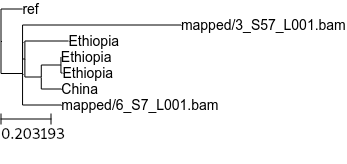

In [11]:
def create_tree(filename, labelmap=None):
    """Draw a tree """
    
    from ete3 import Tree, NodeStyle, TreeStyle
    t = Tree(filename)
    t.set_outgroup('ref')    
    if labelmap != None:
        trees.set_tiplabels(t,labelmap)
    trees.format_nodes(t)
    ts = TreeStyle()
    ts.scale=1000
    t.render("%%inline", tree_style=ts)
    t.render("tree.png", tree_style=ts)
    return t

sra['filename'] = sra.Run.apply(lambda x: 'mapped/'+x+'.bam')
#print (sra[:3])
labelmap = dict(zip(sra.filename,sra.geo_loc_name_country))
#print (labelmap)
t = create_tree('RAxML_bipartitions.variants', labelmap)
t.render("%%inline")

In [35]:
from Bio import Phylo
tree=Phylo.read('RAxML_bestTree.variants','newick')
Phylo.draw(tree)

### Consequence calling

In [ ]:
cmd = 'bcftools csq -f Mbovis_AF212297.fa -g  Mbovis_csq_format.gff col2_mbovis.vcf -Ot -o col2_mbovis.csq.tsv'

In [ ]:
def vcf_to_dataframe(vcf_file, quality=30):

    import vcf
    vcf_reader = vcf.Reader(open(vcf_file,'r'))
    #print (vcf_reader.filters)
    res=[]
    cols = ['chrom','var_type','sub_type','start','end','REF','ALT','QUAL','DP']
    for rec in vcf_reader:
        x = [rec.CHROM, rec.var_type, rec.var_subtype, rec.start, rec.end, rec.REF, str(rec.ALT[0]),
            rec.QUAL, rec.INFO['DP']]
        #print (rec.__dict__)
        #print (rec.INFO.keys())
        for call in rec.samples:
            print (call.sample, call.data, rec.genotype(call.sample))            
            
        res.append(x)
        #print (x)
    
    res = pd.DataFrame(res,columns=cols)
    print (res[:20])
    #print (res.groupby(['var_type','sub_type']).size())
    return res

vcf_to_dataframe('mapped/filtered.recode.vcf')